In [1]:
import re
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

#data preprocessing libraries
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

In [2]:
dataset = pd.read_excel('news_relevancy_training.xlsx') #used as training data
dataset.head()

,Title,Relevancy,Source,Description
0,Apple Gangnam now open in South Korea,irrelevant,Apple,Apple Gangnam now open in South KoreaThe new s...
1,"At Exceptional Minds, autistic artists turn cr...",irrelevant,Apple,"At Exceptional Minds, autistic artists turn cr..."
2,Apple Gangnam will welcome first customers thi...,relevant,Apple,Apple Gangnam will welcome first customers thi...
3,Apple introduces Apple Pay Later,irrelevant,Apple,Apple introduces Apple Pay LaterApple today in...
4,Apple Music Classical is here,irrelevant,Apple,Apple Music Classical is hereApple today launc...


In [3]:
labels = dataset.Relevancy
labels.head()

0    irrelevant
1    irrelevant
2      relevant
3    irrelevant
4    irrelevant
Name: Relevancy, dtype: object

In [4]:
len(dataset)

2444

In [5]:
output_df = dataset.fillna("")

#remove non-english developments and drop duplicates
output_df['Title'] = output_df['Title'].astype(str)
# output_df = output_df[output_df.Title.map(lambda x:x.isascii())]
# output_df = output_df[output_df.Description.map(lambda x:x.isascii())]

output_df = output_df.drop_duplicates(subset=['Title'], keep = "first")

#combine title and description to use as training data
output_df['Description'] = output_df['Title'].astype(str) + ' ' + output_df["Description"].astype(str)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stopwords_eng = stopwords.words('english')

stopwords_eng += ['p', 'style', 'float', 'right', 'margin', '10px', '15px', 'width', 'height','240px',
                  'img', 'src', 'https', 'images', 'com', 'href', 'source', 'jpg', 'cointelegraph', 'www', "768x576",
                 "rss", "feed", "amp", "dmc" "iar", "thn", "udi", "hash", "div"]

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"")
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
#     rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_url) 
    filtered_words = [w for w in tokens if len(w) >= 2 and len(w) < 25 if not w in stopwords_eng and not w.isdigit()]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

output_df['cleanText']=output_df['Description'].map(lambda s:preprocess(s))

dataset=output_df


In [6]:
x_train,x_test,y_train,y_test=train_test_split(dataset['cleanText'], labels, test_size=0.2, random_state=7)

In [7]:
#Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.7)

#Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

In [8]:
#using scikit-learn classifiers

classifier = PassiveAggressiveClassifier(max_iter=1000, random_state=0,tol=1e-3) #works best
# classifier = LogisticRegression()
# classifier = KNeighborsClassifier(n_neighbors=4)
# classifier = RandomForestClassifier(n_estimators=1000,random_state=5)
# classifier = DecisionTreeClassifier()

classifier.fit(tfidf_train,y_train)

#DataFlair - Predict on the test set and calculate accuracy
y_pred=classifier.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

#PAC: 88.18%
#LR: 86.52%
#KNN: 88.42%
#RF: 88.14%

Accuracy: 86.3%


In [9]:
#Build confusion matrix
confusion_matrix(y_test,y_pred, labels=['irrelevant','relevant']) 

#PAC: 340 true positives, 16 true negatives, 35 false positives, 32 false negatives
#LR: 356 true positives, 0 true negatives, 57 false positives, 10 false negatives

array([[338,  30],
       [ 37,  84]], dtype=int64)

In [10]:
#test cases
text = ["Digital Currency created today by bank of canada", 
        "Bank of Montreal in AI modelling", 
        "Governement bans TikTok",
        "Canada explores more in the Metaverse", 
        "Epstein-related reports"]

tfidf_text=tfidf_vectorizer.transform(text)

In [11]:
y_pred=classifier.predict(tfidf_text)
y_pred

array(['relevant', 'relevant', 'irrelevant', 'relevant', 'irrelevant'],
      dtype='<U10')

## save model 

In [12]:
# import pickle
# pickle.dump(classifier, open('model_relevant.pkl', 'wb'))

In [13]:
#load model

# pickled_model = pickle.load(open('model_relevant.pkl', 'rb'))

In [12]:
tfidf_text=tfidf_vectorizer.transform(["BMO has published its 2022 Sustainability reporting suite, including the 2022 BMO Climate Report. The 2022 Sustainability reporting suite provides environmental, social and governance (ESG) disclosure, with a focus on progress BMO has made on issues identified by stakeholders as most affecting the bank's sustainability."])

pred=classifier.predict(tfidf_text)

def relevancy(text):
    text = str(text)
    
    tfidf_text = tfidf_vectorizer.transform([text])
    
    pred = classifier.predict(tfidf_text)
    
    return pred.item()

test = relevancy("BMO has published its 2022 Sustainability reporting suite, including the 2022 BMO Climate Report. The 2022 Sustainability reporting suite provides environmental, social and governance (ESG) disclosure, with a focus on progress BMO has made on issues identified by stakeholders as most affecting the bank's sustainability.")

In [13]:
test

'relevant'

## Predict on new text (All of today's scraped news)

In [18]:
#predict on todays news

df = pd.read_excel('todays_news.xlsx')
df

,Date,Title,Source,Link,Description,cleanText
0,2023-04-11,Ukrainian prime minister expected to appeal fo...,Google,https://news.google.com/rss/articles/CBMieWh0d...,Ukrainian prime minister expected to appeal fo...,ukrainian prime minister expected appeal aid v...
1,2023-04-11,AI bots mingled at a bar and had a party when ...,Cointelegraph,https://cointelegraph.com/news/ai-bots-mingled...,AI bots mingled at a bar and had a party when ...,ai bots mingled bar party researchers gave tow...
2,2023-04-11,Presidential hopefuls RFK Jr. and Ron DeSantis...,Cointelegraph,https://cointelegraph.com/news/presidential-ho...,Presidential hopefuls RFK Jr. and Ron DeSantis...,presidential hopefuls rfk jr ron desantis rail...
3,2023-04-11,Bitcoin Ordinals community debates fix after i...,Cointelegraph,https://cointelegraph.com/news/bitcoin-ordinal...,Bitcoin Ordinals community debates fix after i...,bitcoin ordinals community debates fix inscrip...
4,2023-04-11,Bitcoin hits $30K to mark highest price since ...,Cointelegraph,https://cointelegraph.com/news/bitcoin-hits-30...,Bitcoin hits $30K to mark highest price since ...,bitcoin hits 30k mark highest price since june...
...,...,...,...,...,...,...
961,2023-04-10,World Startup Convention: The India start-up g...,BBC News,https://www.bbc.co.uk/news/world-asia-india-65...,World Startup Convention: The India start-up g...,world startup convention india start gala expl...
962,2023-04-10,Elon Musk: Tesla to build new battery factory ...,BBC News,https://www.bbc.co.uk/news/business-65228927?a...,Elon Musk: Tesla to build new battery factory ...,elon musk tesla build new battery factory shan...
963,2023-04-10,Twitter: BBC objects to 'government funded med...,BBC News,https://www.bbc.co.uk/news/entertainment-arts-...,Twitter: BBC objects to 'government funded med...,twitter bbc objects government funded media la...
964,2023-04-10,"Netflix airs first Welsh language drama, Dal y...",BBC News,https://www.bbc.co.uk/news/uk-wales-65223442?a...,"Netflix airs first Welsh language drama, Dal y...",netflix airs first welsh language drama dal me...


In [19]:
df['Relevancy']=df["cleanText"].apply(lambda x: relevancy(str(x)))

In [21]:
# df = df[df['Relevancy'] == 'relevant']
df.to_excel("output.xlsx", index=False)

## Experiment 2: Using Neural Network

In [81]:
import pandas as pd
import re
import string
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
meaningful_words=[]
stop=set(stopwords.words('english'))

In [82]:
data = pd.read_excel('news_relevancy.xlsx')

data['text'] = data['Description']
data['relevancy'] = data['Relevancy']

In [83]:
#splitting data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.text,data.relevancy,test_size = 0.2) 
x_train.shape

(1955,)

In [84]:
#preprocessing
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')

def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

data['text'] = [clean_up_pipeline(o) for o in data['text']]


data['text'][0]

'apple gangnam now open in south koreathe new space invites customers to discover apple s incredible lineup of products and services  and receive best in class support'

In [85]:
tf = TfidfVectorizer()
t = tf.fit_transform(data['text'])
t.shape

(2444, 14828)

In [86]:
x_train,x_test,y_train,y_test = train_test_split(t,data['Relevancy'],test_size = 0.3)

In [87]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

classifier = MultinomialNB()
clf = SVC(kernel = "rbf", C = 600, gamma = 0.001 )

classifier.fit(x_train,y_train)
clf.fit(x_train,y_train)

SVC(C=600, gamma=0.001)

In [88]:
e = classifier.predict(x_test)
fd = clf.predict(x_test)

In [89]:
s = classifier.score(x_test,y_test)
s1 = clf.score(x_test,y_test)

In [90]:
print(s)
print(s1)

0.7697547683923706
0.8596730245231607


In [91]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes = (6,2), activation = 'tanh',learning_rate = 'adaptive', max_iter = 400)
clf.fit(x_train,y_train)
clf.predict(x_test)

s = clf.score(x_test,y_test)
s

0.8433242506811989

## Keras

In [76]:
from sklearn import preprocessing
import numpy as np
import pandas as pd
import os
# Load required libraries
import matplotlib.pyplot as plt
import time
import pickle
import seaborn as sns
import sys
sys.setrecursionlimit(1500)
%matplotlib inline

In [77]:
dataset = pd.read_excel('news_relevancy.xlsx')
print(f"Total texts: {len(dataset)}")
dataset.head()

Total texts: 2444


,Title,Relevancy,Source,Description
0,Apple Gangnam now open in South Korea,irrelevant,Apple,Apple Gangnam now open in South KoreaThe new s...
1,"At Exceptional Minds, autistic artists turn cr...",irrelevant,Apple,"At Exceptional Minds, autistic artists turn cr..."
2,Apple Gangnam will welcome first customers thi...,relevant,Apple,Apple Gangnam will welcome first customers thi...
3,Apple introduces Apple Pay Later,irrelevant,Apple,Apple introduces Apple Pay LaterApple today in...
4,Apple Music Classical is here,irrelevant,Apple,Apple Music Classical is hereApple today launc...


In [78]:
output_df = dataset.fillna("")

#remove non-english developments and drop duplicates
output_df['Title'] = output_df['Title'].astype(str)
# output_df = output_df[output_df.Title.map(lambda x:x.isascii())]
# output_df = output_df[output_df.Description.map(lambda x:x.isascii())]

output_df = output_df.drop_duplicates(subset=['Title'], keep = "first")

#combine title and description to use as training data
output_df['Description'] = output_df['Title'].astype(str) + ' ' + output_df["Description"].astype(str)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stopwords_eng = stopwords.words('english')

stopwords_eng += ['p', 'style', 'float', 'right', 'margin', '10px', '15px', 'width', 'height','240px',
                  'img', 'src', 'https', 'images', 'com', 'href', 'source', 'jpg', 'cointelegraph', 'www', "768x576",
                 "rss", "feed", "amp", "dmc" "iar", "thn", "udi", "hash", "div"]

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"")
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
#     rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_url) 
    filtered_words = [w for w in tokens if len(w) >= 2 and len(w) < 25 if not w in stopwords_eng and not w.isdigit()]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

output_df['cleanText']=output_df['Description'].map(lambda s:preprocess(s))

dataset=output_df

In [79]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
NEWLINE = '\n'

#We will add two more columns to our dataframe for tokenized text and token count.
def token_count(row):
    'returns token count'
    text=row['tokenized_text']
    length=len(text.split())
    return length

def tokenize(row):
    "tokenize the text using default space tokenizer"
    text=row['cleanText']
    lines=(line for line in text.split(NEWLINE) )
    tokenized=""
    for sentence in lines:
        tokenized+= " ".join(tok for tok in sentence.split())
    return tokenized

In [80]:
dataset['tokenized_text']=dataset.apply(tokenize, axis=1)
dataset['token_count']=dataset.apply(token_count, axis=1)
# Checking the data
dataset.head()

,Title,Relevancy,Source,Description,cleanText,tokenized_text,token_count
0,Apple Gangnam now open in South Korea,irrelevant,Apple,Apple Gangnam now open in South Korea Apple Ga...,apple gangnam open south korea apple gangnam o...,apple gangnam open south korea apple gangnam o...,24
1,"At Exceptional Minds, autistic artists turn cr...",irrelevant,Apple,"At Exceptional Minds, autistic artists turn cr...",exceptional minds autistic artists turn creati...,exceptional minds autistic artists turn creati...,27
2,Apple Gangnam will welcome first customers thi...,relevant,Apple,Apple Gangnam will welcome first customers thi...,apple gangnam welcome first customers friday m...,apple gangnam welcome first customers friday m...,30
3,Apple introduces Apple Pay Later,irrelevant,Apple,Apple introduces Apple Pay Later Apple introdu...,apple introduces apple pay later apple introdu...,apple introduces apple pay later apple introdu...,26
4,Apple Music Classical is here,irrelevant,Apple,Apple Music Classical is here Apple Music Clas...,apple music classical apple music classical he...,apple music classical apple music classical he...,23


In [23]:
dataset['tokenized_text'] = dataset['tokenized_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [24]:
from nltk.stem import *
from nltk.stem.porter import *
stemmer = PorterStemmer()

dataset['tokenized_text'] = dataset['tokenized_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [25]:
import nltk
# nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
dataset['tokenized_text'] = dataset['tokenized_text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
# test_data['tokenized_text'] = test_data['tokenized_text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

In [26]:
# Lets look at some information related to the data
df=dataset
print("total titles : ", len(df))
print  ("total relevant : ", len(df[df['Relevancy']=='relevant']) )
print  ("total irrelevant : ", len(df[df['Relevancy']=='irrelevant']) )

total titles :  2444
total relevant :  625
total irrelevant :  1819


In [27]:
# We randomize the rows to subset the dataframe
df.reset_index(inplace=True)
df=df.reindex(np.random.permutation(df.index))

In [28]:
len_unseen = 1000
df_unseen_test= df.iloc[:len_unseen]
df_model = df.iloc[len_unseen:]

print('total articles for unseen test data : ', len(df_unseen_test))
print('\t total relevant text for enron  : ', len(df_unseen_test['Relevancy']=='relevant'))
print('\t total irrelevant text for enron  : ', len(df_unseen_test['Relevancy']=='irrelevant'))
print()

print('total articles for model training/validation : ', len(df_model))
print('\t total relevant text for enron  : ', len(df_model[(df_model['Relevancy']=='relevant')]))
print('\t total irrelevant text for enron  : ', len(df_model[(df_model['Relevancy']=='irrelevant')]))

total articles for unseen test data :  1000
	 total relevant text for enron  :  1000
	 total irrelevant text for enron  :  1000

total articles for model training/validation :  1444
	 total relevant text for enron  :  360
	 total irrelevant text for enron  :  1084


In [81]:
import keras

from keras.layers import Input, Dense
from keras.models import Model,load_model
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard

import sklearn
from sklearn import metrics
from sklearn import svm
import joblib
from sklearn.preprocessing import LabelEncoder

In [115]:
# max number of features
num_max = 10000

In [116]:
import time

def train_tf_idf_model(texts):
    "train tf idf model "
    tic = time.process_time()
    
    tok = Tokenizer(num_words=num_max)
    tok.fit_on_texts(texts)
    toc = time.process_time()

    print (" -----total Computation time = " + str((toc - tic)) + " seconds")
    return tok

def prepare_model_input(tfidf_model,dataframe,mode='tfidf'):
    
    "function to prepare data input features using tfidf model"
    tic = time.process_time()
    le = LabelEncoder()
    sample_texts = list(dataframe['tokenized_text'])
    sample_texts = [' '.join(x.split()) for x in sample_texts]
    
    targets=list(dataframe['Relevancy'])
    targets = [1. if x=='relevant' else 0. for x in targets]
    sample_target = le.fit_transform(targets)
    
    if mode=='tfidf':
        sample_texts=tfidf_model.texts_to_matrix(sample_texts,mode='tfidf')
    else:
        sample_texts=tfidf_model.texts_to_matrix(sample_texts)
    
    toc = time.process_time()
    
    print('shape of Relevancy: ', sample_target.shape)
    print('shape of data: ', sample_texts.shape)
    
    print (" -----total Computation time for preparing model data = " + str((toc - tic)) + " seconds")
    
    return sample_texts,sample_target

In [117]:
texts=list(df_model['tokenized_text'])
tfidf_model=train_tf_idf_model(texts)

 -----total Computation time = 0.046875 seconds


In [118]:
# prepare model input data
mat_texts,tags=prepare_model_input(tfidf_model,df_model,mode='tfidf')

shape of Relevancy:  (1444,)
shape of data:  (1444, 10000)
 -----total Computation time for preparing model data = 0.125 seconds


In [119]:
#Splitting Training and Testing Data

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(mat_texts, tags, test_size=0.40)
print ('train data shape: ', X_train.shape, y_train.shape)
print ('validation data shape :' , X_val.shape, y_val.shape)

train data shape:  (866, 10000) (866,)
validation data shape : (578, 10000) (578,)


In [120]:
## Define and initialize the network

model_save_path="model/relevancy_detector"

In [121]:
import datetime
def get_simple_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',keras.metrics.binary_accuracy])
    print('compile done')
    return model

def check_model(model,x,y,epochs=2):
    history=model.fit(x,y,batch_size=32,epochs=epochs,verbose=1,shuffle=True,validation_split=0.2,
              callbacks=[checkpointer, tensorboard]).history
    return history


def check_model2(model,x_train,y_train,x_val,y_val,epochs=10):
    history=model.fit(x_train,y_train,batch_size=64,
                      epochs=epochs,verbose=1,
                      shuffle=True,
                      validation_data=(x_val, y_val)).history
    return history

# define checkpointer
checkpointer = ModelCheckpoint(filepath=model_save_path,
                               verbose=1,
                               save_best_only=True)    


# define tensorboard
tensorboard = TensorBoard(log_dir = os.path.join("logs","fit",datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)




# define the predict function for the deep learning model for later use
def predict(data):
    result=model.predict(data)
    prediction = [round(x[0]) for x in result]
    return prediction

In [122]:
# get the compiled model
model = get_simple_model()

# load history
# history=check_model(m,mat_texts,tags,epochs=10)
history=check_model2(model,X_train,y_train,X_val,y_val,epochs=10)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               5120512   
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 1)                 257       
                                                                 
Total params: 5,252,097
Trainable params: 5,252,097
Non-trainable params: 0
_________________________________________________________________
compile done
Epoch 1/10
14/14 [=============

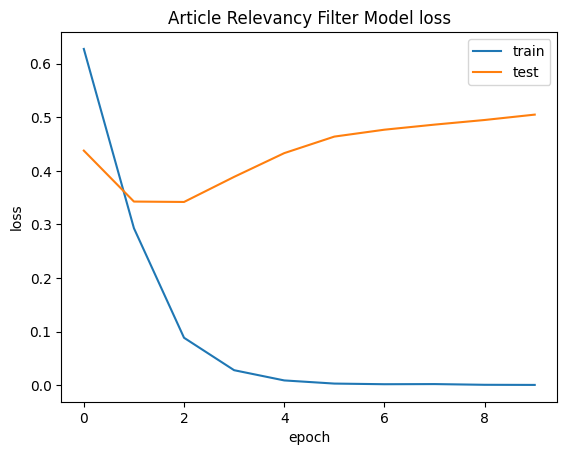

In [123]:
# plot the loss on train and validation data
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Article Relevancy Filter Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [124]:
sample_texts,sample_target=prepare_model_input(tfidf_model,df_unseen_test,mode='')

shape of Relevancy:  (1000,)
shape of data:  (1000, 10000)
 -----total Computation time for preparing model data = 0.421875 seconds


In [125]:
model_dict={}
# model_dict['random_forest']=spam_model_rf
model_dict['neural_networks']=model

In [126]:
def getResults(model_dict,sample_texts,sample_target):
    '''
    Get results from different models
    '''
    results=[]
    
    results_cm={}
    
    for name,model in model_dict.items():
#         print(name)
        tic1 = time.process_time()
        if name in 'neural_networks':
            predicted_sample = predict(sample_texts)
            cm=sklearn.metrics.confusion_matrix(sample_target, predicted_sample)
        else:    
            predicted_sample = model.predict(sample_texts)
            cm=sklearn.metrics.confusion_matrix(sample_target, predicted_sample.round())
            
        toc1 = time.process_time()
#         print(predicted_sample)

        
        results_cm[name]=cm
        
        total=len(predicted_sample)
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]
        
        time_taken=round(toc1 - tic1,4)
        res=sklearn.metrics.precision_recall_fscore_support(sample_target, predicted_sample)
        accuracy=sklearn.metrics.accuracy_score(sample_target, predicted_sample)
        results.append([name,np.mean(res[0]),np.mean(res[1]),np.mean(res[2]),accuracy,TP,FP,FN,TN,str(time_taken)] )
        
    
    df_cols=['model','precision','recall','f1_score','Accuracy','TP','FP','FN','TN','execution_time']
    result_df=pd.DataFrame(results,columns=df_cols)
    
    return result_df,results_cm
    

In [127]:
result_df,results_cm= getResults(model_dict,sample_texts,sample_target)
result_df

32/32 [==============================] - 0s 4ms/step


,model,precision,recall,f1_score,Accuracy,TP,FP,FN,TN,execution_time
0,neural_networks,0.811333,0.799705,0.805171,0.851,668,67,82,183,0.5781


In [128]:
#NN SMR AND HMR COMPUTATION
result_df.iloc[0][5]
HMR = float(result_df.iloc[0][6] / (result_df.iloc[0][8] + result_df.iloc[0][6]))
SMR = float(result_df.iloc[0][7] / (result_df.iloc[0][5] + result_df.iloc[0][7]))

print("NEURAL NETWORK:")
print("irrelevant Misclassification Rate: ",HMR)
print("relevant Misclassification Rate: ", SMR)

NEURAL NETWORK:
irrelevant Misclassification Rate:  0.268
relevant Misclassification Rate:  0.10933333333333334


In [129]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['irrelevant', 'relevant'])
    df_cm2.columns=['irrelevant','relevant']

    ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()

    
    return

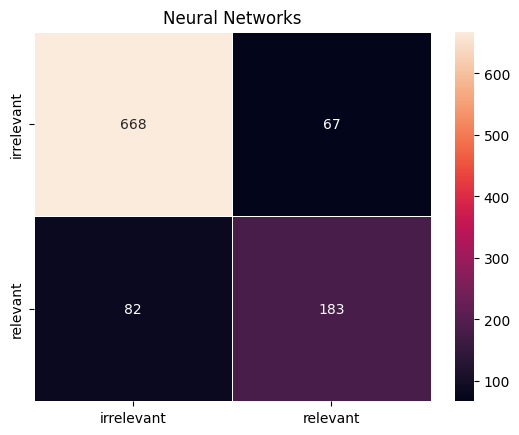

In [130]:
plot_heatmap(results_cm['neural_networks'],'Neural Networks')